# PROJECT FOR DOMAIN APPLICATIONS OF PREDICTIVE ANALYTICS
### POSTGRADUATE IN SCIENCE IN DATA ANALYTICS
### NATIONAL COLLEGE OF IRELAND
### AUTHOR: JORDI BATLLE LALANDE

####################################################################################################
## Personal Loan Modeling
#### Predict whether a customer will respond to a Personal Loan Campaign!
#### Data retrieved from Kaggle: https://www.kaggle.com/teertha/personal-loan-modeling
####################################################################################################

# LOAD LIBRARIES & SETTINGS

In [1]:
from zipfile import ZipFile        
import numpy as np
from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' %x)

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
plt.rcParams['font.family'] = "serif"
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics

# FUNCTIONS SETTINGS

In [2]:
# Function to run basic data frame descriptives
def Descriptives(df):
    print("* Looking at the shape to see the number of records and variables:")
    print(df.shape)    
    print("\n* Sampling the first and last rows of data:")
    print(df.head())
    print(df.tail())
    print("\n* Description of the file to check values range:")
    print(df.describe().transpose())
    print("\n* Attributes and respective data types:")    
    print(df.info(memory_usage='deep'))

# Function to check the memory used by the data frame
def MemUsage(df):
    print("Amount of memory used by each attribute:")
    print(df.memory_usage(deep=True))
    Mem = df.memory_usage(deep=True).sum()
    return Mem

# Function to check the missing values (NaNs)
def Missing(df):
    try:
        assert df.notnull().all().all()
        print(colored("Good news! There are no missing values.", attrs=['bold']))
    
    except AssertionError:
        print("Amount of missing values:")
        print(df.isna().sum())
        print("\nPercentage of missing values:")
        print(df.isna().mean().round(4)*100, "\n")

# Function to format print calls
def Text(s):
    print(colored("#"*50, 'blue', attrs=['bold']))
    print(colored(s, 'blue', attrs=['bold']))
    print(colored("#"*50, 'blue', attrs=['bold']))

# PLOT SETTINGS

In [3]:
def Plot_numeric(x):
    
    print(colored(f'\n*** {x.upper()} ***', attrs=['bold']))
    
    fig = plt.figure(figsize=(15, 3))
    
    plt.subplot(121)
    sns.distplot(data[x], color = 'r')
    plt.xlabel('')
    plt.title(f'{x} Distribution')
    
    plt.subplot(122)
    sns.boxplot(x=data[x], color = 'r', width=0.4, linewidth=2) 
    plt.xlabel('')
    plt.title(f'{x} Boxplot')
    
    plt.show()

In [4]:
def Plot_category(x):
    print(colored(f'\n*** {x.upper()} ***', attrs=['bold']))
    fig, ax = plt.subplots(figsize=(10, 6))
    df = pd.pivot_table(data, index = [x], columns = ['Personal Loan'], aggfunc = len)

    labels = df.index.tolist()
    rejected = df.values[:, 0].tolist()
    accepted = df.values[:, 1].tolist()
    
    l = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(l - width/2, rejected, width, label='Loan Rejected', color = 'salmon')
    rects2 = ax.bar(l + width/2, accepted, width, label='Loan Accepted', color = 'seagreen')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('')
    ax.set_title(f'{x.upper()} BAR CHART')
    ax.set_xticks(l)
    ax.set_xticklabels(labels)
    ax.legend()

    
    def autolabel(rects):
        
        """Attach a text label above each bar in *rects*, displaying its height."""
        
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.0f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()

# LOAD DATA

In [5]:
# Extract files from our ZipFile and save in the input folder
with ZipFile('Bank_Personal_Loan_Modelling.zip', 'r') as zipObj:
    fileName = zipObj.namelist()
    zipObj.extract(fileName[0])

In [6]:
# Read the Data
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

# START THE DATAFRAME ANALYSIS AND SETUP

In [7]:
Descriptives(data)

* Looking at the shape to see the number of records and variables:
(5000, 14)

* Sampling the first and last rows of data:
   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  Personal Loan  Securities Account  CD Account  Online  CreditCard
0  1   25   1           49      91107     4      1.600   1          0         0              1                   0           0       0         
1  2   45   19          34      90089     3      1.500   1          0         0              1                   0           0       0         
2  3   39   15          11      94720     1      1.000   1          0         0              0                   0           0       0         
3  4   35   9           100     94112     1      2.700   2          0         0              0                   0           0       0         
4  5   35   8           45      91330     4      1.000   2          0         0              0                   0           0       1         
        ID  A

In [8]:
# Check the memory used by each attribute
MemUsage(data)

Amount of memory used by each attribute:
Index                 128  
ID                    40000
Age                   40000
Experience            40000
Income                40000
ZIP Code              40000
Family                40000
CCAvg                 40000
Education             40000
Mortgage              40000
Personal Loan         40000
Securities Account    40000
CD Account            40000
Online                40000
CreditCard            40000
dtype: int64


560128

In [9]:
# Drop variables:
# ID does not provide any useful information
# ZIPs are all from California
data = data.drop(columns=['ID', 'ZIP Code'])

In [10]:
# Split the variables into numeric and categorical
cols_numeric = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
cols_category = ['Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

In [11]:
# Set data types
data['Age'] = data['Age'].astype('uint8')
data['Experience'] = data['Experience'].astype('int8')
data['Income'] = data['Income'].astype('uint8')
data['CCAvg'] = pd.to_numeric(data['CCAvg'], downcast='unsigned')
data['Mortgage'] = pd.to_numeric(data['Mortgage'], downcast='unsigned')

for x in cols_category:
    data[x] = data[x].astype('category')

In [12]:
# Check the missing values
Missing(data)

Good news! There are no missing values.


# NUMERIC VARIABLES


*** AGE ***


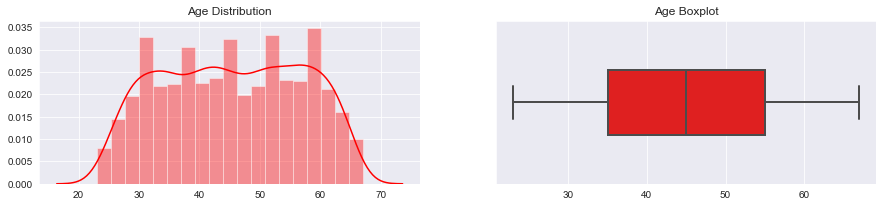


*** EXPERIENCE ***


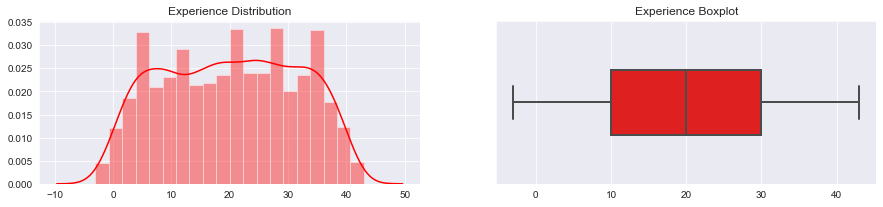


*** INCOME ***


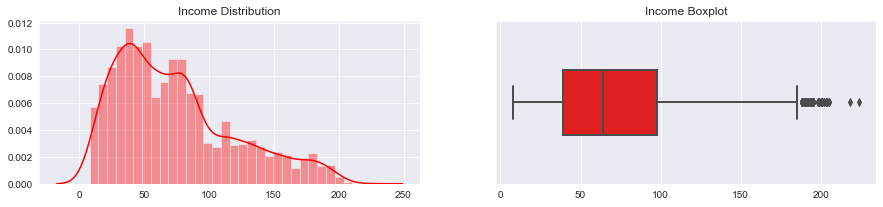


*** CCAVG ***


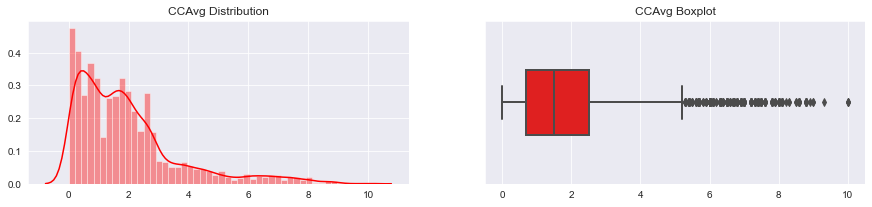


*** MORTGAGE ***


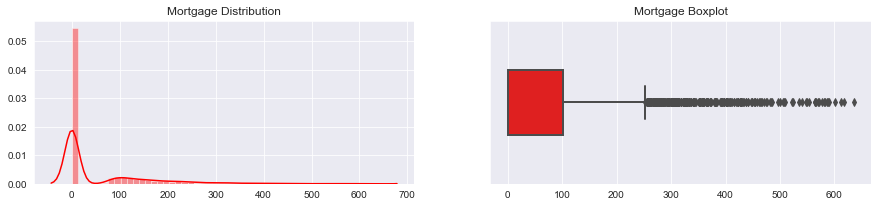

In [13]:
for x in cols_numeric:
    Plot_numeric(x)

Preliminary observations:
- Age distribution is uniform and there are no outliers
- Experience distribution is uniform and there are no outliers, but there are negative values
- Income distribution is left skewed and some very high values are outside the boxplot
- CCAvg distribution is left skewed and there are many outliers
- Mortgage distribution is left skewed and there are many outliers

For CCAvg and Mortgage, the distribution is "falsen" by the 0 values (customers with no CC spending or no mortgage)
This will be looked at next.


### INCOME

[8.0, 185.0]

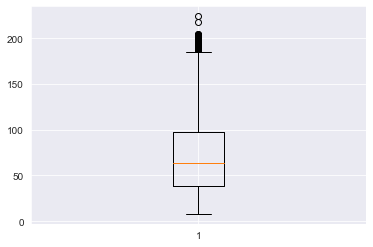

In [14]:
# We found outliers beyond upper whisker
# Find the value of the whisker
[item.get_ydata()[1] for item in plt.boxplot(data['Income'])['whiskers']]

In [15]:
# Check how many values are above 185
print("Count of rows with income bigger than 185 (upper whisker): {:.0f}".format(len(data[data['Income']>185])))
print("This represents {:.2f}% of the total".format(len(data[data['Income']>185])/len(data)*100))

Count of rows with income bigger than 185 (upper whisker): 96
This represents 1.92% of the total


### CCAVG


*** CCAVG ***


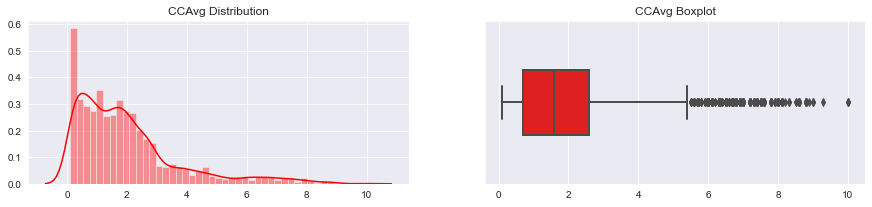

In [16]:
# The values are skewed because of the amount of zeros
# Plot CCAvg again excluding 0 values
x=data[data['CCAvg'] != 0]

print(colored('\n*** CCAVG ***', attrs=['bold']))

fig = plt.figure(figsize=(15, 3))
    
plt.subplot(121)
sns.distplot(x['CCAvg'], color = 'r')
plt.xlabel('')
plt.title('CCAvg Distribution')
    
plt.subplot(122)
sns.boxplot(x['CCAvg'], color = 'r', width=0.4, linewidth=2) 
plt.xlabel('')
plt.title('CCAvg Boxplot')
    
plt.show()

[0.1, 5.4]

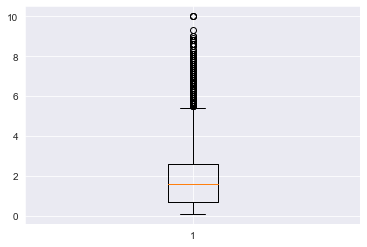

In [17]:
# We found outliers beyond upper whisker
# Find the value of the whisker
[item.get_ydata()[1] for item in plt.boxplot(x['CCAvg'])['whiskers']]

In [18]:
# Check how many values are above 5.4
print("Count of rows with CC average higher than 5.4 (upper whisker): {:.0f}".format(len(data[data['CCAvg']>5.4])))
print("This represents {:.2f}% of the total".format(len(data[data['CCAvg']>5.4])/len(data)*100))

Count of rows with CC average higher than 5.4 (upper whisker): 301
This represents 6.02% of the total


### MORTGAGE


*** MORTGAGE ***


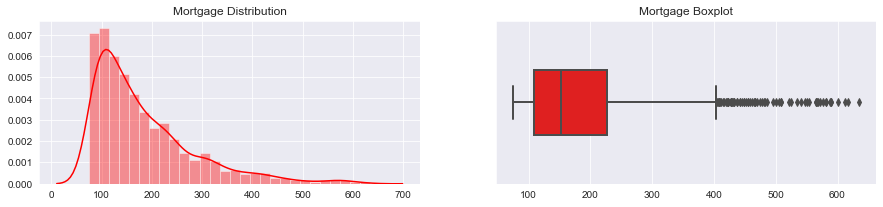

In [19]:
# The values are skewed because of the amount of zeros
# Plot Mortgage again excluding 0 values
x=data[data['Mortgage'] != 0]

print(colored('\n*** MORTGAGE ***', attrs=['bold']))

fig = plt.figure(figsize=(15, 3))
    
plt.subplot(121)
sns.distplot(x['Mortgage'], color = 'r')
plt.xlabel('')
plt.title('Mortgage Distribution')
    
plt.subplot(122)
sns.boxplot(x['Mortgage'], color = 'r', width=0.4, linewidth=2) 
plt.xlabel('')
plt.title('Mortgage Boxplot')
    
plt.show()

[75.0, 403.0]

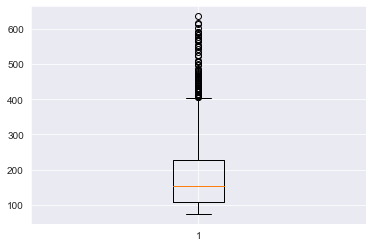

In [20]:
# We found outliers beyond upper whisker
# Find the value of the whisker
[item.get_ydata()[1] for item in plt.boxplot(x['Mortgage'])['whiskers']]

In [21]:
# Check how many values are above 403
print("Count of rows with mortgage higher than 403 (upper whisker): {:.0f}".format(len(data[data['Mortgage']>403])))
print("This represents {:.2f}% of the total".format(len(data[data['Mortgage']>403])/len(data)*100))

Count of rows with mortgage higher than 403 (upper whisker): 70
This represents 1.40% of the total


### REMOVE ROWS WITH OUTLIERS

In [22]:
# As not many rows are affected we can drop the rows
data = data[data['Income']<=185]
data = data[data['CCAvg']<=5.4]
data = data[data['Mortgage']<=403]
#data = data[data['Experience']>=0]

### EXPERIENCE

In [23]:
# There were some negative values
print("Count of rows where experience is negative: {:.0f}".format(len(data[data['Experience']<0])))
print("This represents {:.2f}% of the total".format(len(data[data['Experience']<0])/len(data)*100))

Count of rows where experience is negative: 47
This represents 1.02% of the total


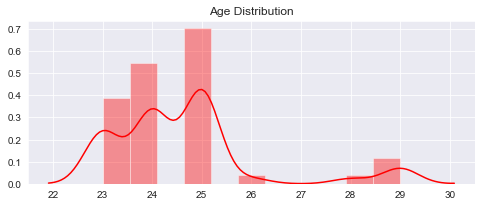

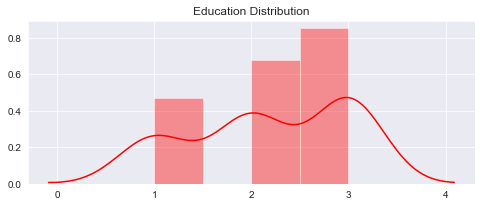

In [24]:
df = data[data['Experience']<0]
for x in ['Age', 'Education']:
    fig = plt.figure(figsize=(8, 3))
    sns.distplot(df[x], color = 'r')
    plt.xlabel('')
    plt.title(f'{x} Distribution')

In [25]:
# From the plots, we can see that those with negative experience:
# are young (<31)
# have "upper" degrees
# so it can make sense to recode to 0 years of experience
data.loc[data['Experience'] < 0, 'Experience'] = 1

### LOOK AT THE CORRELATION

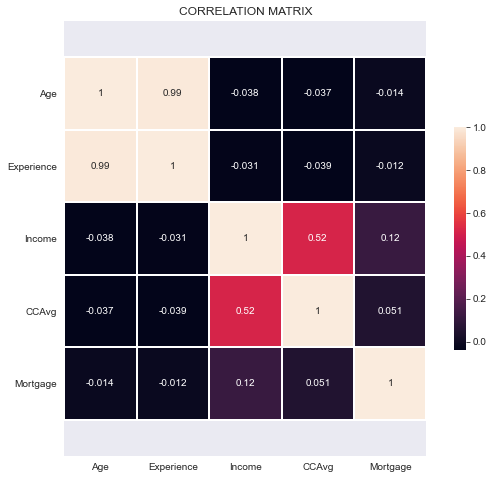

In [26]:
corr = data[cols_numeric].corr()
plt.figure(figsize=(10, 8))
g = sns.heatmap(corr, annot=True, square=True, linewidth=1, cbar_kws={'fraction':0.02})
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.title('CORRELATION MATRIX')
plt.show()

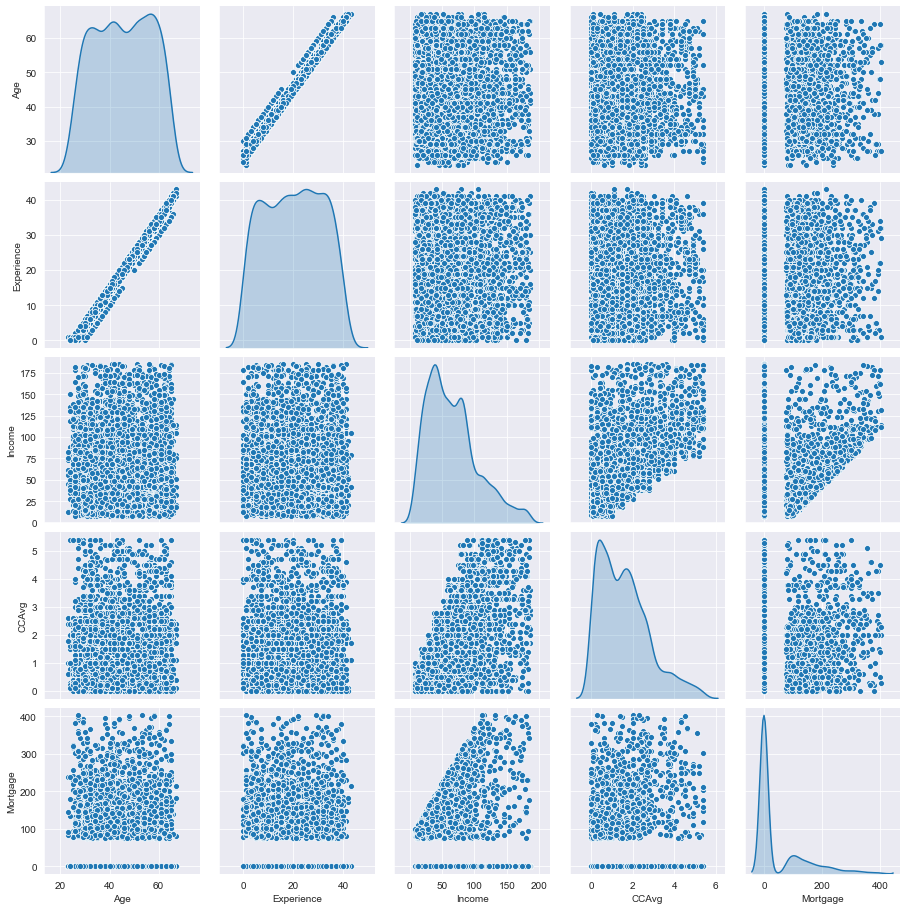

In [27]:
# Found a very high correlation between experience and age which is something that could be expected
# Plotting pairplot for train to confirm results
sns.pairplot(data[cols_numeric], diag_kind = 'kde');

# CATEGORICAL VARIABLES

In [28]:
cols_category.remove('Personal Loan')

In [29]:
print(cols_category)

['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']



*** FAMILY ***


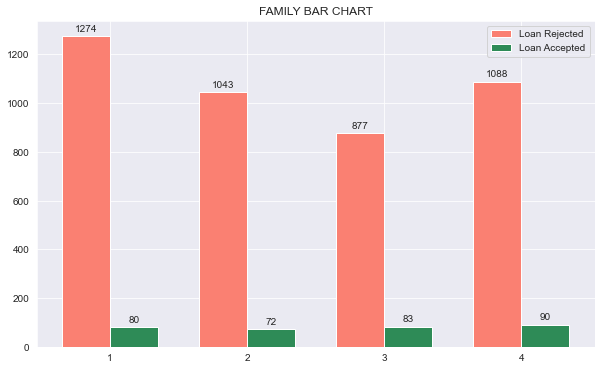


*** EDUCATION ***


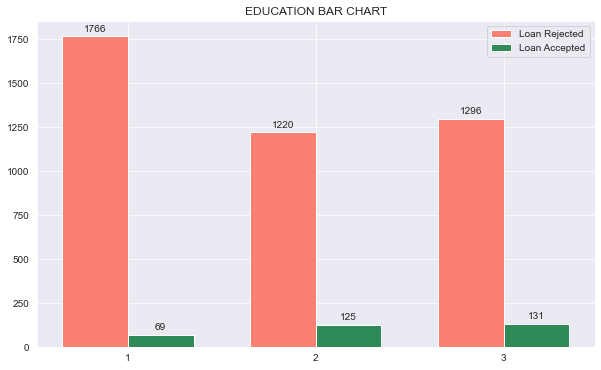


*** SECURITIES ACCOUNT ***


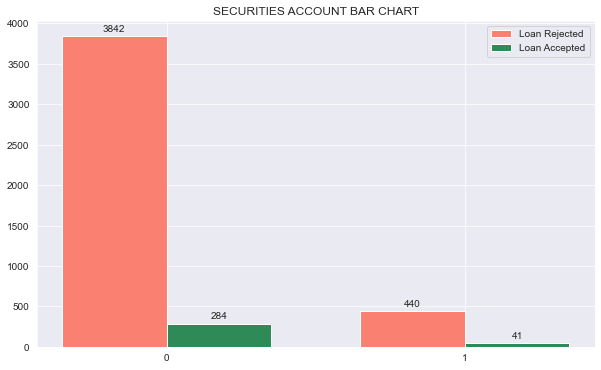


*** CD ACCOUNT ***


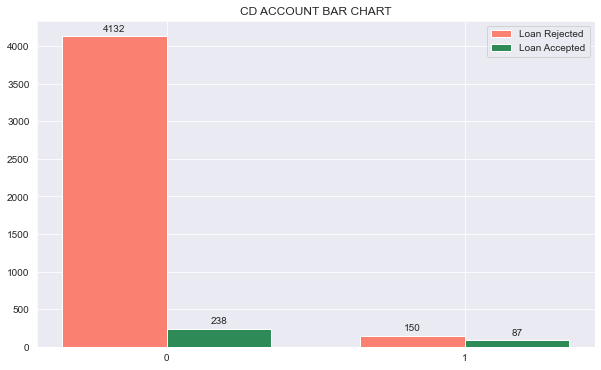


*** ONLINE ***


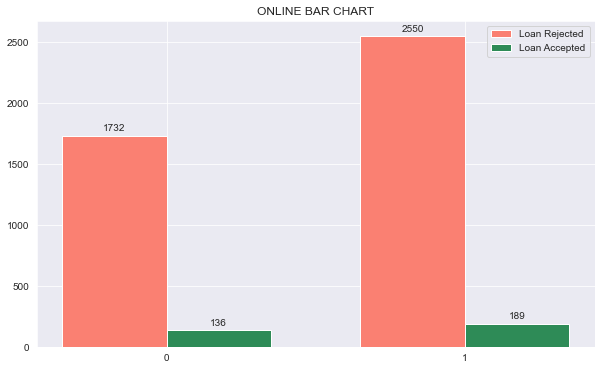


*** CREDITCARD ***


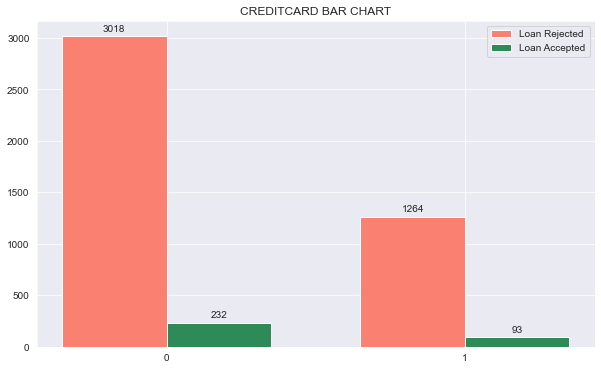

In [30]:
for x in cols_category:
    Plot_category(x)

Some observations:
- Much higher rate of loan rejected (will see later)
- Family size show more acceptance for 3 and 4 members
- Education: higher rate of undergrads (1) and higher rate of acceptance with higher eduction level (2 and 3)
- Securities and CD accounts: higher acceptance rates but they represent a small portion of the total amount of customers (5%)
- Internet banking: higher rate of client with ebanking with similar acceptance rate
- Having a credit card issued by the bank does not seem to make any difference

# TARGET VARIABLE: PERSONAL LOAN

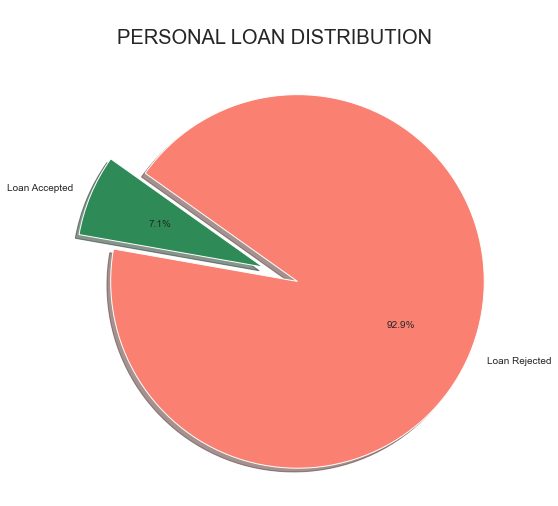

In [31]:
# Data to plot
fig, ax = plt.subplots(figsize=(8, 8))
labels = 'Loan Rejected', 'Loan Accepted'
sizes = [len(data[data['Personal Loan']==0]), len(data[data['Personal Loan']==1])]
colors = ['salmon', 'seagreen']
explode = (0.2, 0)  

# Plot
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=170)
fig.suptitle('\nPERSONAL LOAN DISTRIBUTION', fontsize=20)
plt.axis('equal')
plt.show()

We can observe a very high class imbalance

FINAL LOOK AT THE DATASET

In [32]:
Descriptives(data)

* Looking at the shape to see the number of records and variables:
(4607, 12)

* Sampling the first and last rows of data:
   Age  Experience  Income Family  CCAvg Education  Mortgage Personal Loan Securities Account CD Account Online CreditCard
0  25   1           49      4     1.600   1         0         0             1                  0          0      0        
1  45   19          34      3     1.500   1         0         0             1                  0          0      0        
2  39   15          11      1     1.000   1         0         0             0                  0          0      0        
3  35   9           100     1     2.700   2         0         0             0                  0          0      0        
4  35   8           45      4     1.000   2         0         0             0                  0          0      1        
      Age  Experience  Income Family  CCAvg Education  Mortgage Personal Loan Securities Account CD Account Online CreditCard
4995  29   3 

# DATA TRANSFORMATION

### Transform: make dummies for categories and scale numerical

In [33]:
data = pd.get_dummies(data, prefix=['Family', 'Education'], columns=['Family', 'Education'])

In [34]:
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [35]:
df.columns = list(data.columns)
data = df
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4607.000,0.511,0.262,0.000,0.273,0.523,0.727,1.000
Experience,4607.000,0.471,0.267,0.000,0.233,0.465,0.698,1.000
Income,4607.000,0.329,0.221,0.000,0.169,0.294,0.435,1.000
CCAvg,4607.000,0.295,0.222,0.000,0.111,0.259,0.426,1.000
Mortgage,4607.000,0.124,0.215,0.000,0.000,0.000,0.238,1.000
Personal Loan,4607.000,0.071,0.256,0.000,0.000,0.000,0.000,1.000
Securities Account,4607.000,0.104,0.306,0.000,0.000,0.000,0.000,1.000
CD Account,4607.000,0.051,0.221,0.000,0.000,0.000,0.000,1.000
Online,4607.000,0.595,0.491,0.000,0.000,1.000,1.000,1.000
CreditCard,4607.000,0.295,0.456,0.000,0.000,0.000,1.000,1.000


# BUILD THE MODEL

### Setting the train/test split

In [36]:
# Split and save the target variable
X = data.drop('Personal Loan', axis = 1)
Y = data[['Personal Loan']]

In [37]:
# set the train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=123,
                                                    stratify=Y)

### XG Boost

In [38]:
model = XGBClassifier(objective='binary:logistic',n_estimators=300, random_state=123)
print(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=123, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


In [39]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Set predictions on test data

In [40]:
predictions = model.predict(X_test)

In [41]:
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
auc = roc_auc_score(Y_test, predictions)
print(f'Accuracy: {accuracy:.3}\nPrecision:{precision:.3}\nRecall: {recall:.3}\nAUC score: {auc:.3}')

Accuracy: 0.982
Precision:0.895
Recall: 0.84
AUC score: 0.916


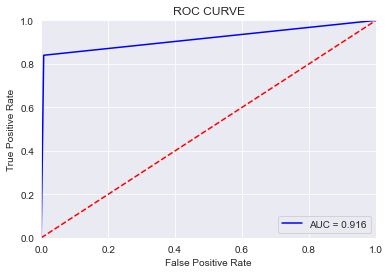

In [42]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC CURVE')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

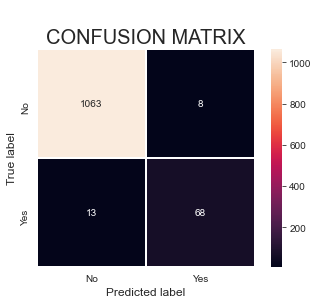

In [43]:
cm = confusion_matrix(Y_test, predictions)
labels = ['No', 'Yes']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, square=True, annot=True, linewidth=1, fmt="d")
plt.title("\nCONFUSION MATRIX", fontsize=20)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

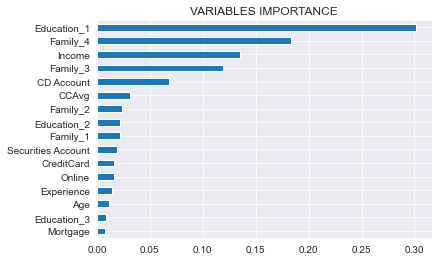

In [44]:
model_importances = pd.Series(model.feature_importances_, index=X_train.columns)
model_importances.sort_values(ascending=True).plot(kind='barh',title='VARIABLES IMPORTANCE');